In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#auto
#plt.ioff()

##### TODO: select the strongest peaks only

peaks = np.load('cxitut13_peaks233.npy')
iX = np.load('cxitut13_iX.npy')
iY = np.load('cxitut13_iY.npy')

cx = 877 # self.parent.cx
cy = 864 # self.parent.cy

photonEnergy = 8.06 # keV
D = 0.158 # m
pixSize = 110e-6 # m
wavelength = 12.407002 / float(photonEnergy) * 1e-10  # m

cenX = iX[np.array(peaks[:, 0], dtype=np.int64),
          np.array(peaks[:, 1], dtype=np.int64),
          np.array(peaks[:, 2], dtype=np.int64)] + 0.5 # pixels
cenY = iY[np.array(peaks[:, 0], dtype=np.int64),
          np.array(peaks[:, 1], dtype=np.int64),
          np.array(peaks[:, 2], dtype=np.int64)] + 0.5 # pixels

#strongInd = np.where(cenX > 500) and np.where(cenX < 1100) and np.where(cenY > 500) and np.where(cenY < 1100)
#cenX = cenX[strongInd]
#cenY = cenY[strongInd]

Xd = (cenX - cx) * pixSize # m
Yd = (cenY - cy) * pixSize # m
r = np.sqrt(Xd**2 + Yd**2 + D**2) # m
s = np.array([D/r-1, Xd/r, Yd/r]) / (wavelength) # m^-1

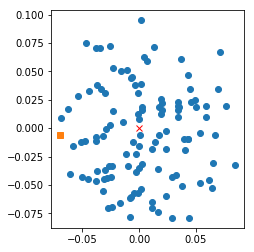

('pixels: ', -633.5, -56.5)


In [2]:
plt.plot(Xd,Yd,'o')
plt.plot(Xd[108],Yd[108],'s')
plt.plot(0,0,'rx')
plt.axis('scaled')
plt.show()
print("pixels: ", Xd[108]/pixSize,Yd[108]/pixSize)

('s0: ', array([ -3.57518748e+08,  -1.70313205e+09,   1.27147249e+09]), 2155254214.2170777)


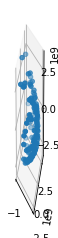

In [3]:
_,numPeaks = s.shape

#norm = np.sqrt(x ** 2 + y ** 2 + z ** 2)
#qPeaks = np.array([x,y,z])/(wavelength*norm)
#s = np.array([D/r-1, Xd/r, Yd/r]) # unitless        

print("s0: ",s[:,0], np.sqrt(np.sum(s[:,0]**2)))
#print(qPeaks)

import matplotlib.pyplot as plt
#plt.plot(y,x,'o')
#plt.plot(0,0,'rx')
#plt.axis('equal')
#plt.show()

#plt.plot(qPeaks[0,:],qPeaks[1,:],'o')
#plt.plot(0,0,'rx')
#plt.axis('equal')
#plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(*s)
ax.set_aspect('equal')
plt.show()

#ind = 5
#print(np.sqrt(qPeaks[0,ind]**2+qPeaks[1,ind]**2+(qPeaks[2,ind])**2))

In [4]:
import math, random

def fibonacci_sphere(samples=1,randomize=True):
    rnd = 1.
    if randomize:
        rnd = random.random() * samples

    points = np.zeros((samples,3))
    offset = 2./samples
    increment = math.pi * (3. - math.sqrt(5.));
    print(offset, increment, increment*180/(2*3.14))

    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2);
        r = math.sqrt(1 - pow(y,2))

        phi = ((i + rnd) % samples) * increment
        
        x = math.cos(phi) * r
        z = math.sin(phi) * r

        if z > 0:
            points[i,0] = -x
            points[i,1] = y
            points[i,2] = -z          
        else:
            points[i,0] = x
            points[i,1] = y
            points[i,2] = z

    return points

(6.666666666666667e-05, 2.399963229728653, 68.78875499222254)


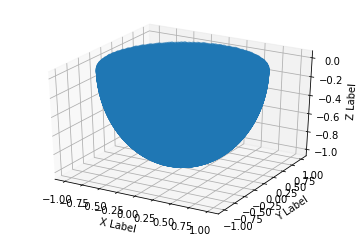

In [5]:
numSamples=30000
pts = fibonacci_sphere(samples=numSamples)
tx = pts[:,1]
ty = pts[:,2]
tz = pts[:,0]

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#plt.axis('equal')
plt.show()

In [7]:
def fj(signal, nBins):
    maxSignal = np.max(signal)
    bins = np.linspace(0, maxSignal, nBins)
    binSize = maxSignal/nBins
    digitized = np.digitize(signal, bins)
    ff = np.zeros((nBins,))
    for i in digitized:
        ff[i-1] += 1
    return ff, bins, binSize

_f = np.zeros((numSamples,numPeaks))
numBins = 2800
f = np.zeros((numSamples,numBins))
F = np.zeros((numSamples,int(numBins/2)))
candidate = []
candidateVec = []
candidateLen = []
candidateLikely = []
threshF = 50
gap = 5
for j in range(numSamples):
    t = np.array([tx[j], ty[j], tz[j]])
    for i in range(numPeaks):
        q = s[:,i] # Bragg spots in reciprocal space
        p = np.abs(np.dot(q, t)) # Bragg spots projected on to vector t
        _f[j,i] = p 
    f[j,:],bins,binSize = fj(_f[j,:],numBins)   
    sp = np.fft.fftshift(abs(np.fft.fft(f[j,:])))
    F[j,:] = sp[int(numBins/2)::]
    if len(np.where(F[j,gap::]>threshF)[0]):
        candidate.append(j)
        print("candidate: ", j)
        candidateVec.append(t)
        print("t: ", t)
        #print("q: ", q)
        #print("p: ", p)
        #print("binSize: ", binSize)
        ii = np.where(F[j,gap::]>threshF)[0][0]
        print("pos: ", ii+gap)
        likely = F[j,ii+gap]
        print(likely)
        x_real = (ii+gap) / (numBins * binSize)
        print("unit cell basis vector (real-space dimension): ", x_real)
        candidateLen.append(x_real)
        candidateLikely.append(likely)
        fRange = (numBins * binSize) # m^-1
        FbinSize = 1/fRange # m
        #Faxis = range(F.shape[1]) * FbinSize * 1e10 # Angstroms
        #plt.subplot(121)
        #plt.plot(bins,f[j,:])
        #plt.subplot(122)
        #plt.plot(Faxis,F[j,:])
        #plt.xlabel('Axis length (A)')
        #plt.xticks(np.array([0,50,100,150,200]))
        #plt.show()
        #break
print(candidate)

('candidate: ', 1793)
('t: ', array([-0.88043333, -0.46407127, -0.09733964]))
('pos: ', 19)
50.8029534176
('unit cell basis vector (real-space dimension): ', 1.0993487943933943e-08)
('candidate: ', 1865)
('t: ', array([-0.87563333, -0.47363505, -0.09453099]))
('pos: ', 19)
65.8895174402
('unit cell basis vector (real-space dimension): ', 1.0856988072432282e-08)
('candidate: ', 1937)
('t: ', array([-0.87083333, -0.48298636, -0.09150674]))
('pos: ', 19)
52.1093498755
('unit cell basis vector (real-space dimension): ', 1.072751159237046e-08)
('candidate: ', 3613)
('t: ', array([-0.7591    , -0.39822818,  0.51495777]))
('pos: ', 36)
52.8002579102
('unit cell basis vector (real-space dimension): ', 1.3412142813811596e-08)
('candidate: ', 4487)
('t: ', array([-0.70083333, -0.70950822, -0.07369341]))
('pos: ', 20)
56.4267283903
('unit cell basis vector (real-space dimension): ', 8.8266486746046361e-09)
('candidate: ', 4509)
('t: ', array([-0.69936667, -0.54140634, -0.46665345]))
('pos: ', 49)

('candidate: ', 15449)
('t: ', array([ 0.02996667, -0.75140755,  0.65915757]))
('pos: ', 36)
56.5434462008
('unit cell basis vector (real-space dimension): ', 1.175723179967732e-08)
('candidate: ', 16814)
('t: ', array([ 0.12096667, -0.9925939 , -0.0111545 ]))
('pos: ', 27)
51.2323696621
('unit cell basis vector (real-space dimension): ', 8.7810950921945218e-09)
('candidate: ', 16886)
('t: ', array([ 0.12576667, -0.99205876, -0.00146891]))
('pos: ', 27)
57.0556710705
('unit cell basis vector (real-space dimension): ', 8.7421498440071877e-09)
('candidate: ', 17119)
('t: ', array([ 0.1413    , -0.98987607, -0.01340421]))
('pos: ', 27)
55.7340011829
('unit cell basis vector (real-space dimension): ', 8.7622568826524428e-09)
('candidate: ', 17191)
('t: ', array([ 0.1461    , -0.98926274, -0.00374327]))
('pos: ', 27)
63.6684534497
('unit cell basis vector (real-space dimension): ', 8.7242212252404406e-09)
('candidate: ', 17496)
('t: ', array([ 0.16643333, -0.98603444, -0.00600217]))
('pos: 

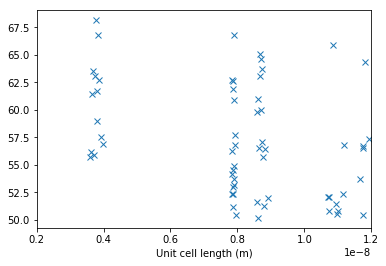

In [8]:
plt.plot(candidateLen,candidateLikely,'x')
plt.xlim([20e-10,120e-10])
plt.xlabel('Unit cell length (m)')
plt.show()

In [9]:
for ind in range(len(candidateLen)):
    print(ind,candidateVec[ind],candidateLikely[ind],candidateLen[ind])

(0, array([-0.88043333, -0.46407127, -0.09733964]), 50.802953417553802, 1.0993487943933943e-08)
(1, array([-0.87563333, -0.47363505, -0.09453099]), 65.889517440197281, 1.0856988072432282e-08)
(2, array([-0.87083333, -0.48298636, -0.09150674]), 52.109349875464474, 1.072751159237046e-08)
(3, array([-0.7591    , -0.39822818,  0.51495777]), 52.800257910185501, 1.3412142813811596e-08)
(4, array([-0.70083333, -0.70950822, -0.07369341]), 56.426728390349297, 8.8266486746046361e-09)
(5, array([-0.69936667, -0.54140634, -0.46665345]), 54.461323356931324, 2.0849288824143638e-08)
(6, array([-0.6853    , -0.72340414, -0.08396644]), 64.574709009465067, 8.7106874865002857e-09)
(7, array([-0.6805    , -0.72865103, -0.07737845]), 65.028705857234357, 8.6746575130546487e-09)
(8, array([-0.66976667, -0.73653331, -0.09450554]), 50.192039227145479, 8.6049343279350346e-09)
(9, array([-0.66496667, -0.74169187, -0.08782088]), 59.80738831694714, 8.5707049738637079e-09)
(10, array([-0.65443333, -0.37203235, -0.6

In [10]:
print(np.dot(candidateVec[9],candidateVec[11]))
print(np.dot(candidateVec[9],candidateVec[19]))

0.982411197883
0.920107818401


In [11]:
mostLikelyInd = np.argsort(candidateLikely)[::-1]

In [22]:
shortListVec = []
shortListLen = []
for i,val in enumerate(mostLikelyInd):
    duplicate = False
    _len = candidateLen[val]
    _vec = candidateVec[val]
    if i == 0: 
        shortListLen.append(_len)
        shortListVec.append(_vec)
    else:
        for j,val2 in enumerate(shortListLen):
            if np.abs(_len-val2) < 1e-9 and np.dot(_vec,shortListVec[j]) > 0.95:
                duplicate = True
        if not duplicate:
            shortListLen.append(_len)
            shortListVec.append(_vec)

In [23]:
shortListLen, shortListVec

([3.7690732559752201e-09,
  7.8827256847524214e-09,
  8.7409254833420463e-09,
  8.6436725774629888e-09,
  7.8490565403443823e-09,
  8.75797438162788e-09,
  1.809660375747834e-08,
  1.176803580822151e-08,
  1.7986653254265764e-08,
  1.1116747264591108e-08,
  1.6058430987767172e-08,
  1.616363397827349e-08,
  1.176299442248114e-08,
  1.3506700926461909e-08,
  1.8053945434799452e-08,
  1.1935551949027251e-08,
  2.0918935107772551e-08,
  1.0965371591545414e-08,
  1.3530229488904851e-08,
  1.093210662927812e-08,
  1.7503533181215118e-08,
  1.921278631043632e-08,
  1.3790430376871112e-08,
  1.6150878281320392e-08,
  1.3432037100536825e-08,
  8.9153270503738095e-09,
  2.5177572526579963e-08,
  1.6255232802470931e-08,
  1.7800192378155433e-08,
  1.3469350684218538e-08],
 [array([ 0.94503333, -0.31426579,  0.09027187]),
  array([-0.10676667, -0.01813984,  0.99411862]),
  array([-0.6895    , -0.71975646, -0.08087266]),
  array([ 0.48683333, -0.12286116, -0.86481122]),
  array([-0.29583333, -0.95

In [174]:
# Step 1
Gzero = []
for i in np.arange(-5,5):
    for j in np.arange(-5,5):
        for k in np.arange(-5,5):
            if i == 0 and j == 0 and k == 0:
                continue
            Gzero.append([i,j,k])
            
Gone = []
for i, val in enumerate(Gzero):
    if np.dot(val,val) <= 6:
        Gone.append(val)

#for i in Gone:
#    for j in Gone:
#        if np.cross(i,j) == 0:
#            print("remove: ", j)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [161]:
# Checkpoint1: Volume test
_a = shortListVec[0]*shortListLen[0]
_b = shortListVec[1]*shortListLen[1]
_c = shortListVec[2]*shortListLen[2]
V = np.dot(np.cross(_a,_b),_c) 
print(V)
_t = shortListLen[0]*shortListLen[1]*shortListLen[2]/100
print(_t)
print(V > _t) # True means pass

2.295417755170825e-25
2.5877979155449913e-27
True


In [ ]:
# Checkpoint2: rmsd test between f and h

In [ ]:
# Checkpoint3: 

In [ ]:
# Checkpoint4: rmsd test between x and h

In [ ]:
# Checkpoint5: fraction of predicted vs observed

In [24]:
# Manually selected vectors 0, 1, and 4
a = shortListVec[0]*shortListLen[0]
b = shortListVec[1]*shortListLen[1]
c = shortListVec[4]*shortListLen[4]
print(a)
print(b)
print(c)

[  3.56189986e-09  -1.18449079e-09   3.40241293e-10]
[ -8.41612346e-10  -1.42991365e-10   7.83636436e-09]
[ -2.32201256e-09  -7.48700954e-09  -4.00792244e-10]


In [25]:
print(np.arccos(np.dot(shortListVec[0],shortListVec[1])) * 180/(np.pi))
print(np.arccos(np.dot(shortListVec[4],shortListVec[0])) * 180/(np.pi))
print(np.arccos(np.dot(shortListVec[4],shortListVec[1])) * 180/(np.pi))

90.3126291718
89.1068346102
90.1073666653


In [26]:
A = np.matrix([b,c,a]) # m
print(A)

[[ -8.41612346e-10  -1.42991365e-10   7.83636436e-09]
 [ -2.32201256e-09  -7.48700954e-09  -4.00792244e-10]
 [  3.56189986e-09  -1.18449079e-09   3.40241293e-10]]


In [27]:
from numpy.linalg import inv
Ainv = inv(A) # m^-1
print(Ainv)
astar = Ainv[:,0]
bstar = Ainv[:,1]
cstar = Ainv[:,2]

[[ -1.29611590e+07  -3.96000265e+07   2.51871194e+08]
 [ -2.73424275e+06  -1.20937368e+08  -7.94854630e+07]
 [  1.26168298e+08  -6.45973926e+06   2.56001587e+07]]


In [28]:
s[:,108] # reciprocal orthonormal basis

array([ -5.56277970e+08,  -2.61982685e+09,  -2.33654644e+08])

In [30]:
print(A)
print(s[:,108])
f = np.dot(A,s[:,108])
h = np.round(f)
#f = A * s[:,108] # reciprocal unit cell basis vectors
print("f: ", f)
print("h,k,l: ", h)

[[ -8.41612346e-10  -1.42991365e-10   7.83636436e-09]
 [ -2.32201256e-09  -7.48700954e-09  -4.00792244e-10]
 [  3.56189986e-09  -1.18449079e-09   3.40241293e-10]]
[ -5.56277970e+08  -2.61982685e+09  -2.33654644e+08]
('f: ', matrix([[ -0.9882199,  21.       ,   1.0422554]]))
('h,k,l: ', matrix([[ -1.,  21.,   1.]]))
